In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=7, height=7, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
        self.reward=(1/self.tmp)**2
#         self.reward+=(1/self.tmp)**0.5

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=5e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 3000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 4000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 5000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 6000
Best mean reward: -inf - Last mean reward per episode: 22.25
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 7000
Best mean reward: 22.25 - Last mean reward per episode: 22.06
Num timesteps: 8000
Best mean reward: 22.25 - Last mean reward per episode: 22.22
Num timesteps: 9000
Best mean reward: 22.25 - Last mean reward per episode: 22.18
Num timesteps: 10000
Best mean reward: 22.25 - Last mean reward per episode: 30.22
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 11000
Best mean reward: 30.22 - Last mean reward per episode: 250.19
Saving new 

Num timesteps: 95000
Best mean reward: 7567.46 - Last mean reward per episode: 23.18
Num timesteps: 96000
Best mean reward: 7567.46 - Last mean reward per episode: 23.07
Num timesteps: 97000
Best mean reward: 7567.46 - Last mean reward per episode: 203.63
Num timesteps: 98000
Best mean reward: 7567.46 - Last mean reward per episode: 22.83
Num timesteps: 99000
Best mean reward: 7567.46 - Last mean reward per episode: 22.59
Num timesteps: 100000
Best mean reward: 7567.46 - Last mean reward per episode: 22.50
Num timesteps: 101000
Best mean reward: 7567.46 - Last mean reward per episode: 22.39
Num timesteps: 102000
Best mean reward: 7567.46 - Last mean reward per episode: 22.23
Num timesteps: 103000
Best mean reward: 7567.46 - Last mean reward per episode: 22.27
Num timesteps: 104000
Best mean reward: 7567.46 - Last mean reward per episode: 22.43
Num timesteps: 105000
Best mean reward: 7567.46 - Last mean reward per episode: 23.36
Num timesteps: 106000
Best mean reward: 7567.46 - Last mea

Num timesteps: 190000
Best mean reward: 9816.15 - Last mean reward per episode: 23.39
Num timesteps: 191000
Best mean reward: 9816.15 - Last mean reward per episode: 4773.01
Num timesteps: 192000
Best mean reward: 9816.15 - Last mean reward per episode: 29.39
Num timesteps: 193000
Best mean reward: 9816.15 - Last mean reward per episode: 22.70
Num timesteps: 194000
Best mean reward: 9816.15 - Last mean reward per episode: 22.48
Num timesteps: 195000
Best mean reward: 9816.15 - Last mean reward per episode: 22.88
Num timesteps: 196000
Best mean reward: 9816.15 - Last mean reward per episode: 22.43
Num timesteps: 197000
Best mean reward: 9816.15 - Last mean reward per episode: 26.80
Num timesteps: 198000
Best mean reward: 9816.15 - Last mean reward per episode: 22.66
Num timesteps: 199000
Best mean reward: 9816.15 - Last mean reward per episode: 275.24
Num timesteps: 200000
Best mean reward: 9816.15 - Last mean reward per episode: 22.08
Num timesteps: 201000
Best mean reward: 9816.15 - L

Num timesteps: 286000
Best mean reward: 9816.15 - Last mean reward per episode: 859.76
Num timesteps: 287000
Best mean reward: 9816.15 - Last mean reward per episode: 473.95
Num timesteps: 288000
Best mean reward: 9816.15 - Last mean reward per episode: 21.80
Num timesteps: 289000
Best mean reward: 9816.15 - Last mean reward per episode: 21.82
Num timesteps: 290000
Best mean reward: 9816.15 - Last mean reward per episode: 72.19
Num timesteps: 291000
Best mean reward: 9816.15 - Last mean reward per episode: 21.87
Num timesteps: 292000
Best mean reward: 9816.15 - Last mean reward per episode: 21.92
Num timesteps: 293000
Best mean reward: 9816.15 - Last mean reward per episode: 22.45
Num timesteps: 294000
Best mean reward: 9816.15 - Last mean reward per episode: 22.15
Num timesteps: 295000
Best mean reward: 9816.15 - Last mean reward per episode: 22.13
Num timesteps: 296000
Best mean reward: 9816.15 - Last mean reward per episode: 22.15
Num timesteps: 297000
Best mean reward: 9816.15 - La

Num timesteps: 382000
Best mean reward: 9816.15 - Last mean reward per episode: 19.75
Num timesteps: 383000
Best mean reward: 9816.15 - Last mean reward per episode: nan
Num timesteps: 384000
Best mean reward: 9816.15 - Last mean reward per episode: 19.69
Num timesteps: 385000
Best mean reward: 9816.15 - Last mean reward per episode: 19.86
Num timesteps: 386000
Best mean reward: 9816.15 - Last mean reward per episode: 19.17
Num timesteps: 387000
Best mean reward: 9816.15 - Last mean reward per episode: 19.14
Num timesteps: 388000
Best mean reward: 9816.15 - Last mean reward per episode: 19.34
Num timesteps: 389000
Best mean reward: 9816.15 - Last mean reward per episode: 68.47
Num timesteps: 390000
Best mean reward: 9816.15 - Last mean reward per episode: 19.19
Num timesteps: 391000
Best mean reward: 9816.15 - Last mean reward per episode: 534.92
Num timesteps: 392000
Best mean reward: 9816.15 - Last mean reward per episode: 21.92
Num timesteps: 393000
Best mean reward: 9816.15 - Last 

Num timesteps: 478000
Best mean reward: 9816.15 - Last mean reward per episode: 19.45
Num timesteps: 479000
Best mean reward: 9816.15 - Last mean reward per episode: 19.44
Num timesteps: 480000
Best mean reward: 9816.15 - Last mean reward per episode: 19.55
Num timesteps: 481000
Best mean reward: 9816.15 - Last mean reward per episode: 19.55
Num timesteps: 482000
Best mean reward: 9816.15 - Last mean reward per episode: 19.59
Num timesteps: 483000
Best mean reward: 9816.15 - Last mean reward per episode: 26.08
Num timesteps: 484000
Best mean reward: 9816.15 - Last mean reward per episode: 19.41
Num timesteps: 485000
Best mean reward: 9816.15 - Last mean reward per episode: 20.13
Num timesteps: 486000
Best mean reward: 9816.15 - Last mean reward per episode: 20.13
Num timesteps: 487000
Best mean reward: 9816.15 - Last mean reward per episode: 87.86
Num timesteps: 488000
Best mean reward: 9816.15 - Last mean reward per episode: 19.40
Num timesteps: 489000
Best mean reward: 9816.15 - Last

Num timesteps: 574000
Best mean reward: 9816.15 - Last mean reward per episode: 19.51
Num timesteps: 575000
Best mean reward: 9816.15 - Last mean reward per episode: 19.50
Num timesteps: 576000
Best mean reward: 9816.15 - Last mean reward per episode: 19.48
Num timesteps: 577000
Best mean reward: 9816.15 - Last mean reward per episode: 19.47
Num timesteps: 578000
Best mean reward: 9816.15 - Last mean reward per episode: 19.57
Num timesteps: 579000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 580000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 581000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 582000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 583000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 584000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 585000
Best mean reward: 9816.15 - Last

Num timesteps: 670000
Best mean reward: 9816.15 - Last mean reward per episode: 19.59
Num timesteps: 671000
Best mean reward: 9816.15 - Last mean reward per episode: 19.60
Num timesteps: 672000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 673000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 674000
Best mean reward: 9816.15 - Last mean reward per episode: 28.42
Num timesteps: 675000
Best mean reward: 9816.15 - Last mean reward per episode: 19.44
Num timesteps: 676000
Best mean reward: 9816.15 - Last mean reward per episode: 19.29
Num timesteps: 677000
Best mean reward: 9816.15 - Last mean reward per episode: 19.51
Num timesteps: 678000
Best mean reward: 9816.15 - Last mean reward per episode: 19.55
Num timesteps: 679000
Best mean reward: 9816.15 - Last mean reward per episode: 19.54
Num timesteps: 680000
Best mean reward: 9816.15 - Last mean reward per episode: 21.33
Num timesteps: 681000
Best mean reward: 9816.15 - Last

Num timesteps: 766000
Best mean reward: 9816.15 - Last mean reward per episode: 19.57
Num timesteps: 767000
Best mean reward: 9816.15 - Last mean reward per episode: 19.57
Num timesteps: 768000
Best mean reward: 9816.15 - Last mean reward per episode: 30.13
Num timesteps: 769000
Best mean reward: 9816.15 - Last mean reward per episode: 19.88
Num timesteps: 770000
Best mean reward: 9816.15 - Last mean reward per episode: 30.17
Num timesteps: 771000
Best mean reward: 9816.15 - Last mean reward per episode: nan
Num timesteps: 772000
Best mean reward: 9816.15 - Last mean reward per episode: 19.42
Num timesteps: 773000
Best mean reward: 9816.15 - Last mean reward per episode: 19.61
Num timesteps: 774000
Best mean reward: 9816.15 - Last mean reward per episode: 19.63
Num timesteps: 775000
Best mean reward: 9816.15 - Last mean reward per episode: 19.62
Num timesteps: 776000
Best mean reward: 9816.15 - Last mean reward per episode: 19.50
Num timesteps: 777000
Best mean reward: 9816.15 - Last m

Num timesteps: 862000
Best mean reward: 9816.15 - Last mean reward per episode: 19.47
Num timesteps: 863000
Best mean reward: 9816.15 - Last mean reward per episode: 19.47
Num timesteps: 864000
Best mean reward: 9816.15 - Last mean reward per episode: 19.47
Num timesteps: 865000
Best mean reward: 9816.15 - Last mean reward per episode: 19.47
Num timesteps: 866000
Best mean reward: 9816.15 - Last mean reward per episode: 19.46
Num timesteps: 867000
Best mean reward: 9816.15 - Last mean reward per episode: 19.38
Num timesteps: 868000
Best mean reward: 9816.15 - Last mean reward per episode: 19.58
Num timesteps: 869000
Best mean reward: 9816.15 - Last mean reward per episode: 19.59
Num timesteps: 870000
Best mean reward: 9816.15 - Last mean reward per episode: 19.59
Num timesteps: 871000
Best mean reward: 9816.15 - Last mean reward per episode: 19.60
Num timesteps: 872000
Best mean reward: 9816.15 - Last mean reward per episode: 19.60
Num timesteps: 873000
Best mean reward: 9816.15 - Last

Num timesteps: 957000
Best mean reward: 9965.78 - Last mean reward per episode: 23.24
Num timesteps: 958000
Best mean reward: 9965.78 - Last mean reward per episode: 19.47
Num timesteps: 959000
Best mean reward: 9965.78 - Last mean reward per episode: 20.24
Num timesteps: 960000
Best mean reward: 9965.78 - Last mean reward per episode: 22.80
Num timesteps: 961000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 962000
Best mean reward: 9965.78 - Last mean reward per episode: 32.85
Num timesteps: 963000
Best mean reward: 9965.78 - Last mean reward per episode: 19.86
Num timesteps: 964000
Best mean reward: 9965.78 - Last mean reward per episode: 7942.59
Num timesteps: 965000
Best mean reward: 9965.78 - Last mean reward per episode: 19.42
Num timesteps: 966000
Best mean reward: 9965.78 - Last mean reward per episode: 19.94
Num timesteps: 967000
Best mean reward: 9965.78 - Last mean reward per episode: 22.93
Num timesteps: 968000
Best mean reward: 9965.78 - Last

Num timesteps: 1052000
Best mean reward: 9965.78 - Last mean reward per episode: 19.58
Num timesteps: 1053000
Best mean reward: 9965.78 - Last mean reward per episode: 19.46
Num timesteps: 1054000
Best mean reward: 9965.78 - Last mean reward per episode: 982.36
Num timesteps: 1055000
Best mean reward: 9965.78 - Last mean reward per episode: 80.60
Num timesteps: 1056000
Best mean reward: 9965.78 - Last mean reward per episode: 19.42
Num timesteps: 1057000
Best mean reward: 9965.78 - Last mean reward per episode: 3432.82
Num timesteps: 1058000
Best mean reward: 9965.78 - Last mean reward per episode: 19.45
Num timesteps: 1059000
Best mean reward: 9965.78 - Last mean reward per episode: 112.42
Num timesteps: 1060000
Best mean reward: 9965.78 - Last mean reward per episode: 19.56
Num timesteps: 1061000
Best mean reward: 9965.78 - Last mean reward per episode: 22.25
Num timesteps: 1062000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1063000
Best mean reward

Num timesteps: 1147000
Best mean reward: 9965.78 - Last mean reward per episode: 45.79
Num timesteps: 1148000
Best mean reward: 9965.78 - Last mean reward per episode: 19.53
Num timesteps: 1149000
Best mean reward: 9965.78 - Last mean reward per episode: 35.55
Num timesteps: 1150000
Best mean reward: 9965.78 - Last mean reward per episode: 19.40
Num timesteps: 1151000
Best mean reward: 9965.78 - Last mean reward per episode: 19.91
Num timesteps: 1152000
Best mean reward: 9965.78 - Last mean reward per episode: 19.99
Num timesteps: 1153000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1154000
Best mean reward: 9965.78 - Last mean reward per episode: 19.59
Num timesteps: 1155000
Best mean reward: 9965.78 - Last mean reward per episode: 19.64
Num timesteps: 1156000
Best mean reward: 9965.78 - Last mean reward per episode: 26.88
Num timesteps: 1157000
Best mean reward: 9965.78 - Last mean reward per episode: 19.59
Num timesteps: 1158000
Best mean reward: 99

Num timesteps: 1242000
Best mean reward: 9965.78 - Last mean reward per episode: 19.35
Num timesteps: 1243000
Best mean reward: 9965.78 - Last mean reward per episode: 3662.99
Num timesteps: 1244000
Best mean reward: 9965.78 - Last mean reward per episode: 26.42
Num timesteps: 1245000
Best mean reward: 9965.78 - Last mean reward per episode: 19.54
Num timesteps: 1246000
Best mean reward: 9965.78 - Last mean reward per episode: 19.33
Num timesteps: 1247000
Best mean reward: 9965.78 - Last mean reward per episode: 25.22
Num timesteps: 1248000
Best mean reward: 9965.78 - Last mean reward per episode: 20.23
Num timesteps: 1249000
Best mean reward: 9965.78 - Last mean reward per episode: 20.40
Num timesteps: 1250000
Best mean reward: 9965.78 - Last mean reward per episode: 20.18
Num timesteps: 1251000
Best mean reward: 9965.78 - Last mean reward per episode: 19.54
Num timesteps: 1252000
Best mean reward: 9965.78 - Last mean reward per episode: 19.57
Num timesteps: 1253000
Best mean reward: 

Num timesteps: 1337000
Best mean reward: 9965.78 - Last mean reward per episode: 19.49
Num timesteps: 1338000
Best mean reward: 9965.78 - Last mean reward per episode: 21.64
Num timesteps: 1339000
Best mean reward: 9965.78 - Last mean reward per episode: 59.59
Num timesteps: 1340000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1341000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1342000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 1343000
Best mean reward: 9965.78 - Last mean reward per episode: 19.41
Num timesteps: 1344000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1345000
Best mean reward: 9965.78 - Last mean reward per episode: 19.60
Num timesteps: 1346000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 1347000
Best mean reward: 9965.78 - Last mean reward per episode: 19.39
Num timesteps: 1348000
Best mean reward: 9965.7

Num timesteps: 1432000
Best mean reward: 9965.78 - Last mean reward per episode: 27.81
Num timesteps: 1433000
Best mean reward: 9965.78 - Last mean reward per episode: 90.60
Num timesteps: 1434000
Best mean reward: 9965.78 - Last mean reward per episode: 19.62
Num timesteps: 1435000
Best mean reward: 9965.78 - Last mean reward per episode: 19.62
Num timesteps: 1436000
Best mean reward: 9965.78 - Last mean reward per episode: 20.46
Num timesteps: 1437000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 1438000
Best mean reward: 9965.78 - Last mean reward per episode: 656.25
Num timesteps: 1439000
Best mean reward: 9965.78 - Last mean reward per episode: 19.57
Num timesteps: 1440000
Best mean reward: 9965.78 - Last mean reward per episode: 19.57
Num timesteps: 1441000
Best mean reward: 9965.78 - Last mean reward per episode: 19.57
Num timesteps: 1442000
Best mean reward: 9965.78 - Last mean reward per episode: 21.31
Num timesteps: 1443000
Best mean reward: 996

Num timesteps: 1527000
Best mean reward: 9965.78 - Last mean reward per episode: 19.47
Num timesteps: 1528000
Best mean reward: 9965.78 - Last mean reward per episode: 19.44
Num timesteps: 1529000
Best mean reward: 9965.78 - Last mean reward per episode: 126.97
Num timesteps: 1530000
Best mean reward: 9965.78 - Last mean reward per episode: 95.87
Num timesteps: 1531000
Best mean reward: 9965.78 - Last mean reward per episode: 19.62
Num timesteps: 1532000
Best mean reward: 9965.78 - Last mean reward per episode: 19.65
Num timesteps: 1533000
Best mean reward: 9965.78 - Last mean reward per episode: 19.65
Num timesteps: 1534000
Best mean reward: 9965.78 - Last mean reward per episode: 24.23
Num timesteps: 1535000
Best mean reward: 9965.78 - Last mean reward per episode: 19.63
Num timesteps: 1536000
Best mean reward: 9965.78 - Last mean reward per episode: 19.93
Num timesteps: 1537000
Best mean reward: 9965.78 - Last mean reward per episode: 39.16
Num timesteps: 1538000
Best mean reward: 9

Num timesteps: 1622000
Best mean reward: 9965.78 - Last mean reward per episode: 110.51
Num timesteps: 1623000
Best mean reward: 9965.78 - Last mean reward per episode: 45.91
Num timesteps: 1624000
Best mean reward: 9965.78 - Last mean reward per episode: 46.34
Num timesteps: 1625000
Best mean reward: 9965.78 - Last mean reward per episode: 24.84
Num timesteps: 1626000
Best mean reward: 9965.78 - Last mean reward per episode: 24.41
Num timesteps: 1627000
Best mean reward: 9965.78 - Last mean reward per episode: 25.21
Num timesteps: 1628000
Best mean reward: 9965.78 - Last mean reward per episode: 57.49
Num timesteps: 1629000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 1630000
Best mean reward: 9965.78 - Last mean reward per episode: 50.13
Num timesteps: 1631000
Best mean reward: 9965.78 - Last mean reward per episode: 25.65
Num timesteps: 1632000
Best mean reward: 9965.78 - Last mean reward per episode: nan
Num timesteps: 1633000
Best mean reward: 9965.

Num timesteps: 1715000
Best mean reward: 10024.82 - Last mean reward per episode: 25.74
Num timesteps: 1716000
Best mean reward: 10024.82 - Last mean reward per episode: 26.48
Num timesteps: 1717000
Best mean reward: 10024.82 - Last mean reward per episode: 26.16
Num timesteps: 1718000
Best mean reward: 10024.82 - Last mean reward per episode: 26.04
Num timesteps: 1719000
Best mean reward: 10024.82 - Last mean reward per episode: 25.77
Num timesteps: 1720000
Best mean reward: 10024.82 - Last mean reward per episode: 25.75
Num timesteps: 1721000
Best mean reward: 10024.82 - Last mean reward per episode: 25.80
Num timesteps: 1722000
Best mean reward: 10024.82 - Last mean reward per episode: 956.63
Num timesteps: 1723000
Best mean reward: 10024.82 - Last mean reward per episode: 398.30
Num timesteps: 1724000
Best mean reward: 10024.82 - Last mean reward per episode: 756.83
Num timesteps: 1725000
Best mean reward: 10024.82 - Last mean reward per episode: nan
Num timesteps: 1726000
Best mea

Num timesteps: 1808000
Best mean reward: 15637.53 - Last mean reward per episode: 27.56
Num timesteps: 1809000
Best mean reward: 15637.53 - Last mean reward per episode: 27.07
Num timesteps: 1810000
Best mean reward: 15637.53 - Last mean reward per episode: 33.97
Num timesteps: 1811000
Best mean reward: 15637.53 - Last mean reward per episode: 27.97
Num timesteps: 1812000
Best mean reward: 15637.53 - Last mean reward per episode: 9888.57
Num timesteps: 1813000
Best mean reward: 15637.53 - Last mean reward per episode: 29.27
Num timesteps: 1814000
Best mean reward: 15637.53 - Last mean reward per episode: 28.15
Num timesteps: 1815000
Best mean reward: 15637.53 - Last mean reward per episode: 28.07
Num timesteps: 1816000
Best mean reward: 15637.53 - Last mean reward per episode: 28.12
Num timesteps: 1817000
Best mean reward: 15637.53 - Last mean reward per episode: 27.86
Num timesteps: 1818000
Best mean reward: 15637.53 - Last mean reward per episode: 27.71
Num timesteps: 1819000
Best me

Num timesteps: 1901000
Best mean reward: 15637.53 - Last mean reward per episode: 25.47
Num timesteps: 1902000
Best mean reward: 15637.53 - Last mean reward per episode: 25.76
Num timesteps: 1903000
Best mean reward: 15637.53 - Last mean reward per episode: 5248.51
Num timesteps: 1904000
Best mean reward: 15637.53 - Last mean reward per episode: 70.64
Num timesteps: 1905000
Best mean reward: 15637.53 - Last mean reward per episode: 25.70
Num timesteps: 1906000
Best mean reward: 15637.53 - Last mean reward per episode: 42.69
Num timesteps: 1907000
Best mean reward: 15637.53 - Last mean reward per episode: 29.78
Num timesteps: 1908000
Best mean reward: 15637.53 - Last mean reward per episode: 25.44
Num timesteps: 1909000
Best mean reward: 15637.53 - Last mean reward per episode: 25.52
Num timesteps: 1910000
Best mean reward: 15637.53 - Last mean reward per episode: 25.19
Num timesteps: 1911000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 1912000
Best mean

Num timesteps: 1995000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 1996000
Best mean reward: 15637.53 - Last mean reward per episode: 71.78
Num timesteps: 1997000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 1998000
Best mean reward: 15637.53 - Last mean reward per episode: 32.59
Num timesteps: 1999000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2000000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2001000
Best mean reward: 15637.53 - Last mean reward per episode: 22.90
Num timesteps: 2002000
Best mean reward: 15637.53 - Last mean reward per episode: 22.98
Num timesteps: 2003000
Best mean reward: 15637.53 - Last mean reward per episode: 23.26
Num timesteps: 2004000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2005000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2006000
Best mean

Num timesteps: 2088000
Best mean reward: 15637.53 - Last mean reward per episode: 23.40
Num timesteps: 2089000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 2090000
Best mean reward: 15637.53 - Last mean reward per episode: 22.99
Num timesteps: 2091000
Best mean reward: 15637.53 - Last mean reward per episode: 9181.31
Num timesteps: 2092000
Best mean reward: 15637.53 - Last mean reward per episode: 22.75
Num timesteps: 2093000
Best mean reward: 15637.53 - Last mean reward per episode: 22.98
Num timesteps: 2094000
Best mean reward: 15637.53 - Last mean reward per episode: 6972.06
Num timesteps: 2095000
Best mean reward: 15637.53 - Last mean reward per episode: 22.98
Num timesteps: 2096000
Best mean reward: 15637.53 - Last mean reward per episode: 59.34
Num timesteps: 2097000
Best mean reward: 15637.53 - Last mean reward per episode: 59.36
Num timesteps: 2098000
Best mean reward: 15637.53 - Last mean reward per episode: 22.90
Num timesteps: 2099000
Best me

Num timesteps: 2182000
Best mean reward: 15637.53 - Last mean reward per episode: 56.13
Num timesteps: 2183000
Best mean reward: 15637.53 - Last mean reward per episode: 22.92
Num timesteps: 2184000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2185000
Best mean reward: 15637.53 - Last mean reward per episode: 23.40
Num timesteps: 2186000
Best mean reward: 15637.53 - Last mean reward per episode: 22.90
Num timesteps: 2187000
Best mean reward: 15637.53 - Last mean reward per episode: 9197.74
Num timesteps: 2188000
Best mean reward: 15637.53 - Last mean reward per episode: 28.67
Num timesteps: 2189000
Best mean reward: 15637.53 - Last mean reward per episode: 22.90
Num timesteps: 2190000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2191000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2192000
Best mean reward: 15637.53 - Last mean reward per episode: 23.40
Num timesteps: 2193000
Best me

Num timesteps: 2276000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 2277000
Best mean reward: 15637.53 - Last mean reward per episode: 23.42
Num timesteps: 2278000
Best mean reward: 15637.53 - Last mean reward per episode: 22.75
Num timesteps: 2279000
Best mean reward: 15637.53 - Last mean reward per episode: 75.18
Num timesteps: 2280000
Best mean reward: 15637.53 - Last mean reward per episode: 105.16
Num timesteps: 2281000
Best mean reward: 15637.53 - Last mean reward per episode: 25.51
Num timesteps: 2282000
Best mean reward: 15637.53 - Last mean reward per episode: 22.99
Num timesteps: 2283000
Best mean reward: 15637.53 - Last mean reward per episode: 23.51
Num timesteps: 2284000
Best mean reward: 15637.53 - Last mean reward per episode: 23.13
Num timesteps: 2285000
Best mean reward: 15637.53 - Last mean reward per episode: 32.86
Num timesteps: 2286000
Best mean reward: 15637.53 - Last mean reward per episode: 22.99
Num timesteps: 2287000
Best mean 

Num timesteps: 2370000
Best mean reward: 15637.53 - Last mean reward per episode: 1.81
Num timesteps: 2371000
Best mean reward: 15637.53 - Last mean reward per episode: 1.82
Num timesteps: 2372000
Best mean reward: 15637.53 - Last mean reward per episode: 1.78
Num timesteps: 2373000
Best mean reward: 15637.53 - Last mean reward per episode: 1.80
Num timesteps: 2374000
Best mean reward: 15637.53 - Last mean reward per episode: 1.81
Num timesteps: 2375000
Best mean reward: 15637.53 - Last mean reward per episode: 1.83
Num timesteps: 2376000
Best mean reward: 15637.53 - Last mean reward per episode: 6961.39
Num timesteps: 2377000
Best mean reward: 15637.53 - Last mean reward per episode: 1.84
Num timesteps: 2378000
Best mean reward: 15637.53 - Last mean reward per episode: 9.87
Num timesteps: 2379000
Best mean reward: 15637.53 - Last mean reward per episode: 40.60
Num timesteps: 2380000
Best mean reward: 15637.53 - Last mean reward per episode: 1.89
Num timesteps: 2381000
Best mean reward

Num timesteps: 2465000
Best mean reward: 15637.53 - Last mean reward per episode: 9.09
Num timesteps: 2466000
Best mean reward: 15637.53 - Last mean reward per episode: 3.98
Num timesteps: 2467000
Best mean reward: 15637.53 - Last mean reward per episode: 4.05
Num timesteps: 2468000
Best mean reward: 15637.53 - Last mean reward per episode: 4.12
Num timesteps: 2469000
Best mean reward: 15637.53 - Last mean reward per episode: 4.17
Num timesteps: 2470000
Best mean reward: 15637.53 - Last mean reward per episode: 4.29
Num timesteps: 2471000
Best mean reward: 15637.53 - Last mean reward per episode: 4.37
Num timesteps: 2472000
Best mean reward: 15637.53 - Last mean reward per episode: 4.52
Num timesteps: 2473000
Best mean reward: 15637.53 - Last mean reward per episode: 4.51
Num timesteps: 2474000
Best mean reward: 15637.53 - Last mean reward per episode: 4.52
Num timesteps: 2475000
Best mean reward: 15637.53 - Last mean reward per episode: 67.62
Num timesteps: 2476000
Best mean reward: 1

Num timesteps: 2559000
Best mean reward: 15637.53 - Last mean reward per episode: 67.57
Num timesteps: 2560000
Best mean reward: 15637.53 - Last mean reward per episode: 176.94
Num timesteps: 2561000
Best mean reward: 15637.53 - Last mean reward per episode: 4.74
Num timesteps: 2562000
Best mean reward: 15637.53 - Last mean reward per episode: 4.75
Num timesteps: 2563000
Best mean reward: 15637.53 - Last mean reward per episode: 4.79
Num timesteps: 2564000
Best mean reward: 15637.53 - Last mean reward per episode: 4.72
Num timesteps: 2565000
Best mean reward: 15637.53 - Last mean reward per episode: 4.75
Num timesteps: 2566000
Best mean reward: 15637.53 - Last mean reward per episode: 4.78
Num timesteps: 2567000
Best mean reward: 15637.53 - Last mean reward per episode: 9.43
Num timesteps: 2568000
Best mean reward: 15637.53 - Last mean reward per episode: 322.46
Num timesteps: 2569000
Best mean reward: 15637.53 - Last mean reward per episode: 5.43
Num timesteps: 2570000
Best mean rewar

Num timesteps: 2653000
Best mean reward: 15637.53 - Last mean reward per episode: 3.69
Num timesteps: 2654000
Best mean reward: 15637.53 - Last mean reward per episode: 12.07
Num timesteps: 2655000
Best mean reward: 15637.53 - Last mean reward per episode: 137.48
Num timesteps: 2656000
Best mean reward: 15637.53 - Last mean reward per episode: 94.66
Num timesteps: 2657000
Best mean reward: 15637.53 - Last mean reward per episode: 70.80
Num timesteps: 2658000
Best mean reward: 15637.53 - Last mean reward per episode: 4.07
Num timesteps: 2659000
Best mean reward: 15637.53 - Last mean reward per episode: 4.31
Num timesteps: 2660000
Best mean reward: 15637.53 - Last mean reward per episode: 4.14
Num timesteps: 2661000
Best mean reward: 15637.53 - Last mean reward per episode: 4.15
Num timesteps: 2662000
Best mean reward: 15637.53 - Last mean reward per episode: 4.17
Num timesteps: 2663000
Best mean reward: 15637.53 - Last mean reward per episode: 4.25
Num timesteps: 2664000
Best mean rewar

Num timesteps: 2747000
Best mean reward: 15637.53 - Last mean reward per episode: 5.45
Num timesteps: 2748000
Best mean reward: 15637.53 - Last mean reward per episode: 55.27
Num timesteps: 2749000
Best mean reward: 15637.53 - Last mean reward per episode: 10.69
Num timesteps: 2750000
Best mean reward: 15637.53 - Last mean reward per episode: 24.47
Num timesteps: 2751000
Best mean reward: 15637.53 - Last mean reward per episode: 144.91
Num timesteps: 2752000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 2753000
Best mean reward: 15637.53 - Last mean reward per episode: 7300.19
Num timesteps: 2754000
Best mean reward: 15637.53 - Last mean reward per episode: 5.74
Num timesteps: 2755000
Best mean reward: 15637.53 - Last mean reward per episode: 13.74
Num timesteps: 2756000
Best mean reward: 15637.53 - Last mean reward per episode: 5.76
Num timesteps: 2757000
Best mean reward: 15637.53 - Last mean reward per episode: 13.76
Num timesteps: 2758000
Best mean r

Num timesteps: 2841000
Best mean reward: 15637.53 - Last mean reward per episode: 3.91
Num timesteps: 2842000
Best mean reward: 15637.53 - Last mean reward per episode: 4.01
Num timesteps: 2843000
Best mean reward: 15637.53 - Last mean reward per episode: 4.09
Num timesteps: 2844000
Best mean reward: 15637.53 - Last mean reward per episode: 4.10
Num timesteps: 2845000
Best mean reward: 15637.53 - Last mean reward per episode: 4.12
Num timesteps: 2846000
Best mean reward: 15637.53 - Last mean reward per episode: 4.04
Num timesteps: 2847000
Best mean reward: 15637.53 - Last mean reward per episode: 4.05
Num timesteps: 2848000
Best mean reward: 15637.53 - Last mean reward per episode: 4.07
Num timesteps: 2849000
Best mean reward: 15637.53 - Last mean reward per episode: 4.11
Num timesteps: 2850000
Best mean reward: 15637.53 - Last mean reward per episode: 4.15
Num timesteps: 2851000
Best mean reward: 15637.53 - Last mean reward per episode: 4.22
Num timesteps: 2852000
Best mean reward: 15

Num timesteps: 2936000
Best mean reward: 15637.53 - Last mean reward per episode: 7.93
Num timesteps: 2937000
Best mean reward: 15637.53 - Last mean reward per episode: 3.32
Num timesteps: 2938000
Best mean reward: 15637.53 - Last mean reward per episode: 3.72
Num timesteps: 2939000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 2940000
Best mean reward: 15637.53 - Last mean reward per episode: 3.20
Num timesteps: 2941000
Best mean reward: 15637.53 - Last mean reward per episode: 93.04
Num timesteps: 2942000
Best mean reward: 15637.53 - Last mean reward per episode: 8.52
Num timesteps: 2943000
Best mean reward: 15637.53 - Last mean reward per episode: 10.87
Num timesteps: 2944000
Best mean reward: 15637.53 - Last mean reward per episode: 3.02
Num timesteps: 2945000
Best mean reward: 15637.53 - Last mean reward per episode: 3.00
Num timesteps: 2946000
Best mean reward: 15637.53 - Last mean reward per episode: 2.98
Num timesteps: 2947000
Best mean reward: 1

Num timesteps: 3031000
Best mean reward: 15637.53 - Last mean reward per episode: 2.65
Num timesteps: 3032000
Best mean reward: 15637.53 - Last mean reward per episode: 2.52
Num timesteps: 3033000
Best mean reward: 15637.53 - Last mean reward per episode: 2.51
Num timesteps: 3034000
Best mean reward: 15637.53 - Last mean reward per episode: 2.46
Num timesteps: 3035000
Best mean reward: 15637.53 - Last mean reward per episode: 2.47
Num timesteps: 3036000
Best mean reward: 15637.53 - Last mean reward per episode: 2.47
Num timesteps: 3037000
Best mean reward: 15637.53 - Last mean reward per episode: 2.52
Num timesteps: 3038000
Best mean reward: 15637.53 - Last mean reward per episode: 2.61
Num timesteps: 3039000
Best mean reward: 15637.53 - Last mean reward per episode: 2.70
Num timesteps: 3040000
Best mean reward: 15637.53 - Last mean reward per episode: 2.73
Num timesteps: 3041000
Best mean reward: 15637.53 - Last mean reward per episode: 2.80
Num timesteps: 3042000
Best mean reward: 15

Num timesteps: 3125000
Best mean reward: 15637.53 - Last mean reward per episode: 6.58
Num timesteps: 3126000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 3127000
Best mean reward: 15637.53 - Last mean reward per episode: 4903.47
Num timesteps: 3128000
Best mean reward: 15637.53 - Last mean reward per episode: 3.17
Num timesteps: 3129000
Best mean reward: 15637.53 - Last mean reward per episode: 3.62
Num timesteps: 3130000
Best mean reward: 15637.53 - Last mean reward per episode: 3.80
Num timesteps: 3131000
Best mean reward: 15637.53 - Last mean reward per episode: 3.33
Num timesteps: 3132000
Best mean reward: 15637.53 - Last mean reward per episode: 3.38
Num timesteps: 3133000
Best mean reward: 15637.53 - Last mean reward per episode: 3.47
Num timesteps: 3134000
Best mean reward: 15637.53 - Last mean reward per episode: 3.51
Num timesteps: 3135000
Best mean reward: 15637.53 - Last mean reward per episode: 47.22
Num timesteps: 3136000
Best mean reward:

Num timesteps: 3219000
Best mean reward: 15637.53 - Last mean reward per episode: 2.60
Num timesteps: 3220000
Best mean reward: 15637.53 - Last mean reward per episode: 2.70
Num timesteps: 3221000
Best mean reward: 15637.53 - Last mean reward per episode: 2.76
Num timesteps: 3222000
Best mean reward: 15637.53 - Last mean reward per episode: 2.91
Num timesteps: 3223000
Best mean reward: 15637.53 - Last mean reward per episode: 2.91
Num timesteps: 3224000
Best mean reward: 15637.53 - Last mean reward per episode: 4.44
Num timesteps: 3225000
Best mean reward: 15637.53 - Last mean reward per episode: 6.71
Num timesteps: 3226000
Best mean reward: 15637.53 - Last mean reward per episode: 3.22
Num timesteps: 3227000
Best mean reward: 15637.53 - Last mean reward per episode: 48.32
Num timesteps: 3228000
Best mean reward: 15637.53 - Last mean reward per episode: 3.53
Num timesteps: 3229000
Best mean reward: 15637.53 - Last mean reward per episode: 4.14
Num timesteps: 3230000
Best mean reward: 1

Num timesteps: 3314000
Best mean reward: 15637.53 - Last mean reward per episode: 50.13
Num timesteps: 3315000
Best mean reward: 15637.53 - Last mean reward per episode: 3.98
Num timesteps: 3316000
Best mean reward: 15637.53 - Last mean reward per episode: 4.01
Num timesteps: 3317000
Best mean reward: 15637.53 - Last mean reward per episode: 611.35
Num timesteps: 3318000
Best mean reward: 15637.53 - Last mean reward per episode: 4.37
Num timesteps: 3319000
Best mean reward: 15637.53 - Last mean reward per episode: 4.49
Num timesteps: 3320000
Best mean reward: 15637.53 - Last mean reward per episode: 4.33
Num timesteps: 3321000
Best mean reward: 15637.53 - Last mean reward per episode: 4.58
Num timesteps: 3322000
Best mean reward: 15637.53 - Last mean reward per episode: 4.59
Num timesteps: 3323000
Best mean reward: 15637.53 - Last mean reward per episode: 4.26
Num timesteps: 3324000
Best mean reward: 15637.53 - Last mean reward per episode: 4.65
Num timesteps: 3325000
Best mean reward:

Num timesteps: 3409000
Best mean reward: 15637.53 - Last mean reward per episode: 4.10
Num timesteps: 3410000
Best mean reward: 15637.53 - Last mean reward per episode: 4.29
Num timesteps: 3411000
Best mean reward: 15637.53 - Last mean reward per episode: 4.38
Num timesteps: 3412000
Best mean reward: 15637.53 - Last mean reward per episode: 4.63
Num timesteps: 3413000
Best mean reward: 15637.53 - Last mean reward per episode: 4.75
Num timesteps: 3414000
Best mean reward: 15637.53 - Last mean reward per episode: 4.83
Num timesteps: 3415000
Best mean reward: 15637.53 - Last mean reward per episode: 4305.48
Num timesteps: 3416000
Best mean reward: 15637.53 - Last mean reward per episode: 5.68
Num timesteps: 3417000
Best mean reward: 15637.53 - Last mean reward per episode: 5.10
Num timesteps: 3418000
Best mean reward: 15637.53 - Last mean reward per episode: 5.15
Num timesteps: 3419000
Best mean reward: 15637.53 - Last mean reward per episode: 952.65
Num timesteps: 3420000
Best mean rewar

Num timesteps: 3503000
Best mean reward: 15637.53 - Last mean reward per episode: 4.06
Num timesteps: 3504000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 3505000
Best mean reward: 15637.53 - Last mean reward per episode: 52.84
Num timesteps: 3506000
Best mean reward: 15637.53 - Last mean reward per episode: 3.96
Num timesteps: 3507000
Best mean reward: 15637.53 - Last mean reward per episode: 3.89
Num timesteps: 3508000
Best mean reward: 15637.53 - Last mean reward per episode: 3.91
Num timesteps: 3509000
Best mean reward: 15637.53 - Last mean reward per episode: 4.39
Num timesteps: 3510000
Best mean reward: 15637.53 - Last mean reward per episode: 3.89
Num timesteps: 3511000
Best mean reward: 15637.53 - Last mean reward per episode: 3.96
Num timesteps: 3512000
Best mean reward: 15637.53 - Last mean reward per episode: 3.95
Num timesteps: 3513000
Best mean reward: 15637.53 - Last mean reward per episode: 3.87
Num timesteps: 3514000
Best mean reward: 15

Num timesteps: 3597000
Best mean reward: 15637.53 - Last mean reward per episode: 9613.87
Num timesteps: 3598000
Best mean reward: 15637.53 - Last mean reward per episode: 4.20
Num timesteps: 3599000
Best mean reward: 15637.53 - Last mean reward per episode: 4.03
Num timesteps: 3600000
Best mean reward: 15637.53 - Last mean reward per episode: 709.13
Num timesteps: 3601000
Best mean reward: 15637.53 - Last mean reward per episode: 3.90
Num timesteps: 3602000
Best mean reward: 15637.53 - Last mean reward per episode: 236.67
Num timesteps: 3603000
Best mean reward: 15637.53 - Last mean reward per episode: 53.79
Num timesteps: 3604000
Best mean reward: 15637.53 - Last mean reward per episode: 3.55
Num timesteps: 3605000
Best mean reward: 15637.53 - Last mean reward per episode: 615.11
Num timesteps: 3606000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 3607000
Best mean reward: 15637.53 - Last mean reward per episode: 3.61
Num timesteps: 3608000
Best mean r

Num timesteps: 3691000
Best mean reward: 15637.53 - Last mean reward per episode: 3.44
Num timesteps: 3692000
Best mean reward: 15637.53 - Last mean reward per episode: 3.48
Num timesteps: 3693000
Best mean reward: 15637.53 - Last mean reward per episode: 3.51
Num timesteps: 3694000
Best mean reward: 15637.53 - Last mean reward per episode: 3.48
Num timesteps: 3695000
Best mean reward: 15637.53 - Last mean reward per episode: 33.54
Num timesteps: 3696000
Best mean reward: 15637.53 - Last mean reward per episode: 3.39
Num timesteps: 3697000
Best mean reward: 15637.53 - Last mean reward per episode: 154.72
Num timesteps: 3698000
Best mean reward: 15637.53 - Last mean reward per episode: 6712.79
Num timesteps: 3699000
Best mean reward: 15637.53 - Last mean reward per episode: 3.52
Num timesteps: 3700000
Best mean reward: 15637.53 - Last mean reward per episode: 3.52
Num timesteps: 3701000
Best mean reward: 15637.53 - Last mean reward per episode: 3.54
Num timesteps: 3702000
Best mean rewa

Num timesteps: 3786000
Best mean reward: 15637.53 - Last mean reward per episode: 6.65
Num timesteps: 3787000
Best mean reward: 15637.53 - Last mean reward per episode: 52.42
Num timesteps: 3788000
Best mean reward: 15637.53 - Last mean reward per episode: 4.81
Num timesteps: 3789000
Best mean reward: 15637.53 - Last mean reward per episode: 4.86
Num timesteps: 3790000
Best mean reward: 15637.53 - Last mean reward per episode: 4.92
Num timesteps: 3791000
Best mean reward: 15637.53 - Last mean reward per episode: 4.90
Num timesteps: 3792000
Best mean reward: 15637.53 - Last mean reward per episode: 5.64
Num timesteps: 3793000
Best mean reward: 15637.53 - Last mean reward per episode: 4.88
Num timesteps: 3794000
Best mean reward: 15637.53 - Last mean reward per episode: 4.78
Num timesteps: 3795000
Best mean reward: 15637.53 - Last mean reward per episode: 4.82
Num timesteps: 3796000
Best mean reward: 15637.53 - Last mean reward per episode: 4.85
Num timesteps: 3797000
Best mean reward: 1

Num timesteps: 3880000
Best mean reward: 15637.53 - Last mean reward per episode: 4.87
Num timesteps: 3881000
Best mean reward: 15637.53 - Last mean reward per episode: 4.97
Num timesteps: 3882000
Best mean reward: 15637.53 - Last mean reward per episode: 5.01
Num timesteps: 3883000
Best mean reward: 15637.53 - Last mean reward per episode: 5.09
Num timesteps: 3884000
Best mean reward: 15637.53 - Last mean reward per episode: 9.98
Num timesteps: 3885000
Best mean reward: 15637.53 - Last mean reward per episode: 63.09
Num timesteps: 3886000
Best mean reward: 15637.53 - Last mean reward per episode: 4928.50
Num timesteps: 3887000
Best mean reward: 15637.53 - Last mean reward per episode: 99.05
Num timesteps: 3888000
Best mean reward: 15637.53 - Last mean reward per episode: 5.14
Num timesteps: 3889000
Best mean reward: 15637.53 - Last mean reward per episode: 5.11
Num timesteps: 3890000
Best mean reward: 15637.53 - Last mean reward per episode: 5.10
Num timesteps: 3891000
Best mean rewar

Num timesteps: 3974000
Best mean reward: 15637.53 - Last mean reward per episode: 10.15
Num timesteps: 3975000
Best mean reward: 15637.53 - Last mean reward per episode: 4.72
Num timesteps: 3976000
Best mean reward: 15637.53 - Last mean reward per episode: 10.00
Num timesteps: 3977000
Best mean reward: 15637.53 - Last mean reward per episode: 4.45
Num timesteps: 3978000
Best mean reward: 15637.53 - Last mean reward per episode: 4.49
Num timesteps: 3979000
Best mean reward: 15637.53 - Last mean reward per episode: 37.65
Num timesteps: 3980000
Best mean reward: 15637.53 - Last mean reward per episode: 60.03
Num timesteps: 3981000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 3982000
Best mean reward: 15637.53 - Last mean reward per episode: 4.58
Num timesteps: 3983000
Best mean reward: 15637.53 - Last mean reward per episode: 5.02
Num timesteps: 3984000
Best mean reward: 15637.53 - Last mean reward per episode: 8146.02
Num timesteps: 3985000
Best mean rewa

Num timesteps: 4068000
Best mean reward: 15637.53 - Last mean reward per episode: 4.14
Num timesteps: 4069000
Best mean reward: 15637.53 - Last mean reward per episode: 4.04
Num timesteps: 4070000
Best mean reward: 15637.53 - Last mean reward per episode: 4.00
Num timesteps: 4071000
Best mean reward: 15637.53 - Last mean reward per episode: 3.95
Num timesteps: 4072000
Best mean reward: 15637.53 - Last mean reward per episode: 3.89
Num timesteps: 4073000
Best mean reward: 15637.53 - Last mean reward per episode: 3.90
Num timesteps: 4074000
Best mean reward: 15637.53 - Last mean reward per episode: 3.85
Num timesteps: 4075000
Best mean reward: 15637.53 - Last mean reward per episode: 3.82
Num timesteps: 4076000
Best mean reward: 15637.53 - Last mean reward per episode: 3.78
Num timesteps: 4077000
Best mean reward: 15637.53 - Last mean reward per episode: 3.75
Num timesteps: 4078000
Best mean reward: 15637.53 - Last mean reward per episode: 3.71
Num timesteps: 4079000
Best mean reward: 15

Num timesteps: 4163000
Best mean reward: 15637.53 - Last mean reward per episode: 3.41
Num timesteps: 4164000
Best mean reward: 15637.53 - Last mean reward per episode: 3.43
Num timesteps: 4165000
Best mean reward: 15637.53 - Last mean reward per episode: 3.37
Num timesteps: 4166000
Best mean reward: 15637.53 - Last mean reward per episode: 3.32
Num timesteps: 4167000
Best mean reward: 15637.53 - Last mean reward per episode: 3.22
Num timesteps: 4168000
Best mean reward: 15637.53 - Last mean reward per episode: 61.36
Num timesteps: 4169000
Best mean reward: 15637.53 - Last mean reward per episode: 11.34
Num timesteps: 4170000
Best mean reward: 15637.53 - Last mean reward per episode: 3.18
Num timesteps: 4171000
Best mean reward: 15637.53 - Last mean reward per episode: 704.81
Num timesteps: 4172000
Best mean reward: 15637.53 - Last mean reward per episode: 3942.02
Num timesteps: 4173000
Best mean reward: 15637.53 - Last mean reward per episode: 3.15
Num timesteps: 4174000
Best mean rew

Num timesteps: 4257000
Best mean reward: 15637.53 - Last mean reward per episode: 4.39
Num timesteps: 4258000
Best mean reward: 15637.53 - Last mean reward per episode: 2473.22
Num timesteps: 4259000
Best mean reward: 15637.53 - Last mean reward per episode: 4.15
Num timesteps: 4260000
Best mean reward: 15637.53 - Last mean reward per episode: 782.55
Num timesteps: 4261000
Best mean reward: 15637.53 - Last mean reward per episode: 4.10
Num timesteps: 4262000
Best mean reward: 15637.53 - Last mean reward per episode: 4.42
Num timesteps: 4263000
Best mean reward: 15637.53 - Last mean reward per episode: 4.13
Num timesteps: 4264000
Best mean reward: 15637.53 - Last mean reward per episode: 7415.53
Num timesteps: 4265000
Best mean reward: 15637.53 - Last mean reward per episode: 3102.30
Num timesteps: 4266000
Best mean reward: 15637.53 - Last mean reward per episode: 5.07
Num timesteps: 4267000
Best mean reward: 15637.53 - Last mean reward per episode: 5.02
Num timesteps: 4268000
Best mean

Num timesteps: 4351000
Best mean reward: 15637.53 - Last mean reward per episode: 11.99
Num timesteps: 4352000
Best mean reward: 15637.53 - Last mean reward per episode: 378.73
Num timesteps: 4353000
Best mean reward: 15637.53 - Last mean reward per episode: 4.39
Num timesteps: 4354000
Best mean reward: 15637.53 - Last mean reward per episode: 8.26
Num timesteps: 4355000
Best mean reward: 15637.53 - Last mean reward per episode: 6586.97
Num timesteps: 4356000
Best mean reward: 15637.53 - Last mean reward per episode: 5.24
Num timesteps: 4357000
Best mean reward: 15637.53 - Last mean reward per episode: 4.35
Num timesteps: 4358000
Best mean reward: 15637.53 - Last mean reward per episode: 1642.10
Num timesteps: 4359000
Best mean reward: 15637.53 - Last mean reward per episode: 7.20
Num timesteps: 4360000
Best mean reward: 15637.53 - Last mean reward per episode: 81.27
Num timesteps: 4361000
Best mean reward: 15637.53 - Last mean reward per episode: 4.22
Num timesteps: 4362000
Best mean 

Num timesteps: 4445000
Best mean reward: 15637.53 - Last mean reward per episode: 3.61
Num timesteps: 4446000
Best mean reward: 15637.53 - Last mean reward per episode: 3.54
Num timesteps: 4447000
Best mean reward: 15637.53 - Last mean reward per episode: 3.63
Num timesteps: 4448000
Best mean reward: 15637.53 - Last mean reward per episode: 79.31
Num timesteps: 4449000
Best mean reward: 15637.53 - Last mean reward per episode: 3.92
Num timesteps: 4450000
Best mean reward: 15637.53 - Last mean reward per episode: 3.68
Num timesteps: 4451000
Best mean reward: 15637.53 - Last mean reward per episode: 4.03
Num timesteps: 4452000
Best mean reward: 15637.53 - Last mean reward per episode: 3.91
Num timesteps: 4453000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4454000
Best mean reward: 15637.53 - Last mean reward per episode: 3.83
Num timesteps: 4455000
Best mean reward: 15637.53 - Last mean reward per episode: 4.58
Num timesteps: 4456000
Best mean reward: 15

Num timesteps: 4540000
Best mean reward: 15637.53 - Last mean reward per episode: 4.46
Num timesteps: 4541000
Best mean reward: 15637.53 - Last mean reward per episode: 4.50
Num timesteps: 4542000
Best mean reward: 15637.53 - Last mean reward per episode: 4.54
Num timesteps: 4543000
Best mean reward: 15637.53 - Last mean reward per episode: 4.63
Num timesteps: 4544000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4545000
Best mean reward: 15637.53 - Last mean reward per episode: 8.42
Num timesteps: 4546000
Best mean reward: 15637.53 - Last mean reward per episode: 8.47
Num timesteps: 4547000
Best mean reward: 15637.53 - Last mean reward per episode: 4.91
Num timesteps: 4548000
Best mean reward: 15637.53 - Last mean reward per episode: 5.01
Num timesteps: 4549000
Best mean reward: 15637.53 - Last mean reward per episode: 5.47
Num timesteps: 4550000
Best mean reward: 15637.53 - Last mean reward per episode: 5.46
Num timesteps: 4551000
Best mean reward: 156

Num timesteps: 4634000
Best mean reward: 15637.53 - Last mean reward per episode: 24.85
Num timesteps: 4635000
Best mean reward: 15637.53 - Last mean reward per episode: 4262.05
Num timesteps: 4636000
Best mean reward: 15637.53 - Last mean reward per episode: 4.17
Num timesteps: 4637000
Best mean reward: 15637.53 - Last mean reward per episode: 4.61
Num timesteps: 4638000
Best mean reward: 15637.53 - Last mean reward per episode: 817.49
Num timesteps: 4639000
Best mean reward: 15637.53 - Last mean reward per episode: 37.27
Num timesteps: 4640000
Best mean reward: 15637.53 - Last mean reward per episode: 2586.69
Num timesteps: 4641000
Best mean reward: 15637.53 - Last mean reward per episode: 36.33
Num timesteps: 4642000
Best mean reward: 15637.53 - Last mean reward per episode: 35.78
Num timesteps: 4643000
Best mean reward: 15637.53 - Last mean reward per episode: 4.53
Num timesteps: 4644000
Best mean reward: 15637.53 - Last mean reward per episode: 429.43
Num timesteps: 4645000
Best m

Num timesteps: 4728000
Best mean reward: 15637.53 - Last mean reward per episode: 3.81
Num timesteps: 4729000
Best mean reward: 15637.53 - Last mean reward per episode: 3.90
Num timesteps: 4730000
Best mean reward: 15637.53 - Last mean reward per episode: 8.31
Num timesteps: 4731000
Best mean reward: 15637.53 - Last mean reward per episode: 70.00
Num timesteps: 4732000
Best mean reward: 15637.53 - Last mean reward per episode: 3.77
Num timesteps: 4733000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4734000
Best mean reward: 15637.53 - Last mean reward per episode: 3.63
Num timesteps: 4735000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4736000
Best mean reward: 15637.53 - Last mean reward per episode: 3.69
Num timesteps: 4737000
Best mean reward: 15637.53 - Last mean reward per episode: 3.71
Num timesteps: 4738000
Best mean reward: 15637.53 - Last mean reward per episode: 3.82
Num timesteps: 4739000
Best mean reward: 156

Num timesteps: 4822000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4823000
Best mean reward: 15637.53 - Last mean reward per episode: 3.10
Num timesteps: 4824000
Best mean reward: 15637.53 - Last mean reward per episode: 3.17
Num timesteps: 4825000
Best mean reward: 15637.53 - Last mean reward per episode: 3.83
Num timesteps: 4826000
Best mean reward: 15637.53 - Last mean reward per episode: 4.55
Num timesteps: 4827000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4828000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4829000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4830000
Best mean reward: 15637.53 - Last mean reward per episode: 9.62
Num timesteps: 4831000
Best mean reward: 15637.53 - Last mean reward per episode: 3.73
Num timesteps: 4832000
Best mean reward: 15637.53 - Last mean reward per episode: 106.68
Num timesteps: 4833000
Best mean reward: 1563

Num timesteps: 4916000
Best mean reward: 15637.53 - Last mean reward per episode: 155.76
Num timesteps: 4917000
Best mean reward: 15637.53 - Last mean reward per episode: 4.70
Num timesteps: 4918000
Best mean reward: 15637.53 - Last mean reward per episode: 3.82
Num timesteps: 4919000
Best mean reward: 15637.53 - Last mean reward per episode: nan
Num timesteps: 4920000
Best mean reward: 15637.53 - Last mean reward per episode: 13.67
Num timesteps: 4921000
Best mean reward: 15637.53 - Last mean reward per episode: 3.93
Num timesteps: 4922000
Best mean reward: 15637.53 - Last mean reward per episode: 3.95
Num timesteps: 4923000
Best mean reward: 15637.53 - Last mean reward per episode: 4.06
Num timesteps: 4924000
Best mean reward: 15637.53 - Last mean reward per episode: 4.12
Num timesteps: 4925000
Best mean reward: 15637.53 - Last mean reward per episode: 789.23
Num timesteps: 4926000
Best mean reward: 15637.53 - Last mean reward per episode: 4.73
Num timesteps: 4927000
Best mean reward

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 117.35116255283356 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
#     print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

In [23]:
print(i)

49



Final Cantilever beam design:


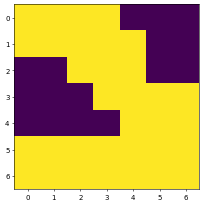

In [24]:
env.render()

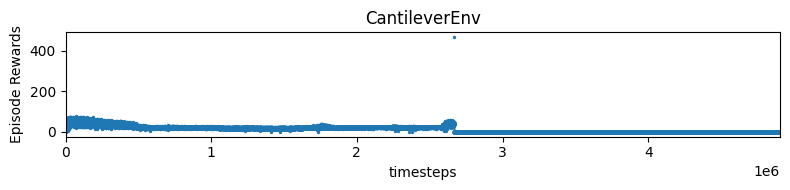

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
#     print(env.tmp, env.const)
    if dones:
        break
    i+=1

In [29]:
i

49


Final Cantilever beam design:


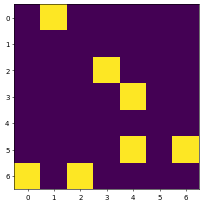

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 

In [32]:
import random

In [33]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<16*0.68753125:
        action = random.randint(0, 15)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rd to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rd` for environment variables or `env.get_wrapper_attr('rd')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for

2779689259.876582 0.16334897959183675
2736132630.124494 0.16334897959183675
4487474871.136236 0.18375510204081635
2574806838.4503164 0.18375510204081635
2573784660.023927 0.20416122448979596
3545413935.052086 0.16334897959183675
4450306745.931582 0.16334897959183675
4591321830.416772 0.18375510204081635
5311952424.149368 0.18375510204081635
3647060786.715314 0.18375510204081635


In [34]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<9*0.68753125:
        action = random.randint(0, 8)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)   

5094064430.872287 0.08172448979591837
3617387625.155642 0.12253673469387756
3780941642.871748 0.10213061224489797
3613522813.74993 0.14294285714285715
3751012082.727226 0.12253673469387756
6024138390.252801 0.12253673469387755
3613522678.302749 0.14294285714285715
3618634512.6415486 0.10213061224489797
3775445913.587989 0.08172448979591837
7056106721.476093 0.08172448979591838
